In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

I posted the following screenshot:

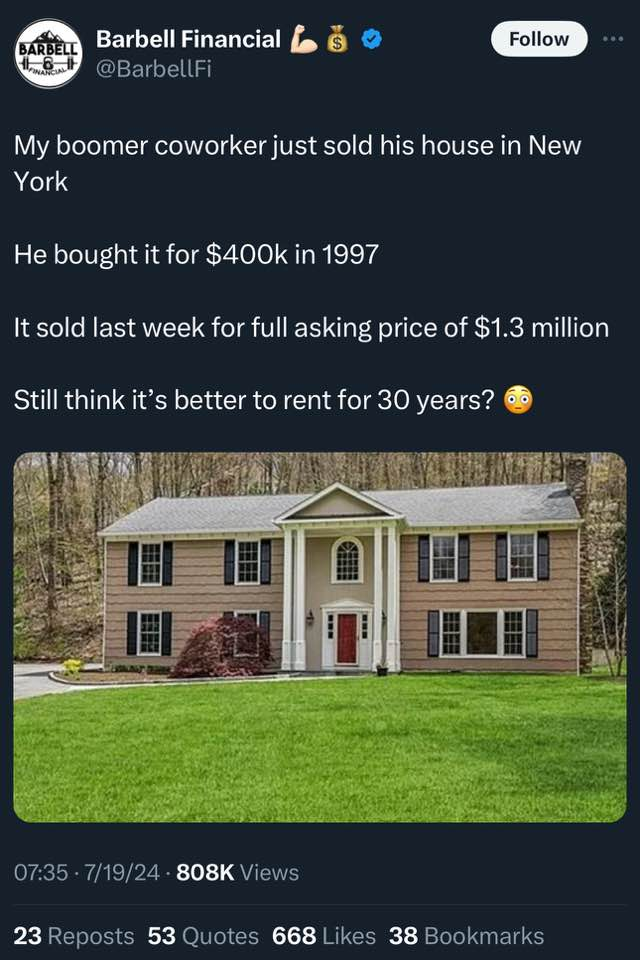

and said:

_If you put your \\$400K into an index fund in 1997, you’d have \\$2.6M today. And you don’t have to replace the roof on a portfolio._

Of course, this was an unfair comparison. The stock market return includes dividends, reinvested back into the market. It's not just an increase in stock prices ("price appreciation"). But the housing return was just appreciaiton. It does not account for the "dividend" -- the rent you implicitly pay to yourself for living in the house.

To compare apples to apples, let's calculate the total cumulative return on the house. In other words, how much money you would have if you bought a house in 1997, rented it out, and reinvested the dividends in other (identical) houses all of which you sold in 2024.

Define start and and year, as well as purchase and sale prices:

In [2]:
start_year = 1997
end_year = 2024

pstart = 400
pend = 1300

## Get Price/Rent Data

Import OECD Price/Rent data for the U.S.:

In [3]:
data = pd.read_csv("price_rent.csv")
data = data[["TIME_PERIOD","OBS_VALUE"]]
data.head()

,TIME_PERIOD,OBS_VALUE
0,1990-Q4,93.158817
1,1970-Q3,92.337174
2,1970-Q4,92.330022
3,2020-Q3,113.368213
4,2020-Q4,118.081556


In [4]:
data["year"] = data["TIME_PERIOD"].str[0:4].astype(int)
data["quarter"] = data["TIME_PERIOD"].str[-1].astype(int)
data.sort_values(["year","quarter"], inplace=True)
data.head()

,TIME_PERIOD,OBS_VALUE,year,quarter
12,1970-Q1,93.890457,1970,1
13,1970-Q2,92.262908,1970,2
1,1970-Q3,92.337174,1970,3
2,1970-Q4,92.330022,1970,4
30,1971-Q1,93.936044,1971,1


Trim the price/rent data accordingly and plot:

In [5]:
data = data.loc[data["year"].between(start_year,end_year),:]
data.head()

,TIME_PERIOD,OBS_VALUE,year,quarter
198,1997-Q1,89.520556,1997,1
199,1997-Q2,89.586181,1997,2
200,1997-Q3,89.538848,1997,3
201,1997-Q4,89.719276,1997,4
202,1998-Q1,90.124351,1998,1


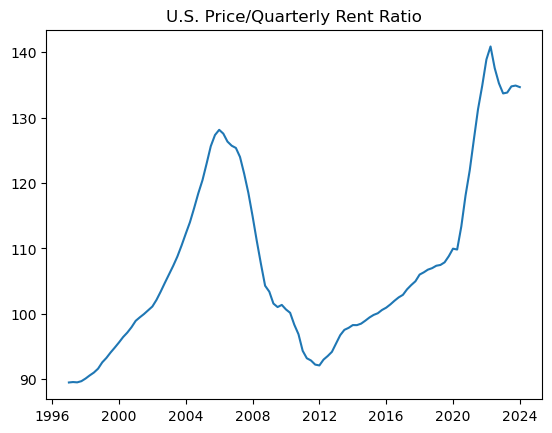

In [6]:
date=data.apply(lambda row: pd.Period(year=row["year"], quarter=row["quarter"], freq='Q'), axis=1).dt.to_timestamp()
plt.plot(date, data["OBS_VALUE"])
plt.title("U.S. Price/Quarterly Rent Ratio")
plt.show()

## Compute Cumulative Returns Using Campbell-Shiller Linearization

Log-linearize $\log(1 + \exp(pd))$ function of the log-PD ratio around its sample mean $\bar{pd}$:

$\log(1 + \exp(pd)) \approx \kappa_0 + \kappa_1 pd$

In [7]:
data["pd"] = np.log(data["OBS_VALUE"])
mean_pd = np.mean(data["pd"])
kappa1 = np.exp(mean_pd)/(1+np.exp(mean_pd))
kappa0 = np.log(1+np.exp(mean_pd)) - kappa1*mean_pd

Check the quality of the approximation:

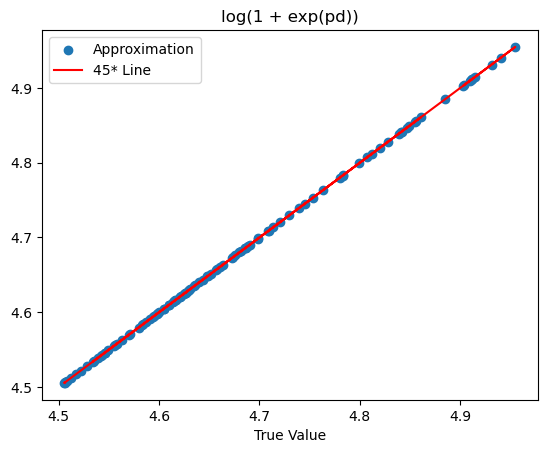

In [8]:
true_value = np.log(1+np.exp(data["pd"]))
plt.scatter(true_value, kappa0 + kappa1 * data["pd"], label="Approximation")
plt.plot(true_value, true_value, 'r', label="45* Line")
plt.xlabel("True Value")
plt.title("log(1 + exp(pd))")
plt.legend()
plt.show()

Infer starting and ending log "dividends" (rents) from prices and log P/D ratios

In [9]:
dstart = np.log(pstart) - data["pd"].iloc[0]
dend = np.log(pend) - data["pd"].iloc[-1]

Calculate cumulative return.

First, observe that $R_{t+1} = \frac{P_{t+1} + D_{t+1}}{P_t} = \frac{P_{t+1}/D_{t+1} + 1}{P_t/D_t} \frac{D_{t+1}}{D_t}$.

Taking logs and using the log-linear approximation above, we get the log return:

$r_{t+1} = \kappa_0 + \kappa_1 pd_{t+1} - pd_t + \Delta d_{t+1}$

Cumulative log return from $0$ to $T$ is $\sum_{t=0}^{T-1} r_{t+1} = d_T - d_0 + (T-1)\kappa_0 + \kappa_1 pd_T - pd_0 + \sum_{t=1}^{T-1}(1-\kappa_1) pd_t $

In [10]:
T = data.shape[0]
r_cum = dend - dstart + (T-1)*kappa0 + kappa1*data["pd"].iloc[-1] - data["pd"].iloc[0] - (1-kappa1)*data["pd"].iloc[1:-1].sum()
R_cum = np.exp(r_cum)

Calculating the future value of the original purhcases including "dividends" (rents):

In [11]:
display(pstart * R_cum)

3554.3606561667298

## Accounting for costs

The price-rent ratio is in terms of gross rents, which may not be a good comparison to a stock dividend, because of ongoing housing costs like property taxes, maintenance, etc.

Suppose that these expenses constitute a share $m$ of gross rents $d_t$. In other words, the net rent is $\hat{d}_t = (1-m) d_t$. This means that log-PD ratios are overstated by a constant $\log(1-m)$. We can recompute the future value as a function of $m$:

In [12]:
def future_value(m):
    pd = np.log(data["OBS_VALUE"]) - np.log(1-m)
    mean_pd = np.mean(pd)
    kappa1 = np.exp(mean_pd)/(1+np.exp(mean_pd))
    kappa0 = np.log(1+np.exp(mean_pd)) - kappa1*mean_pd
    r_cum = dend - dstart + (T-1)*kappa0 + kappa1*pd.iloc[-1] - pd.iloc[0] - (1-kappa1)*pd.iloc[1:-1].sum()
    R_cum = np.exp(r_cum)
    return pstart * R_cum

For $m=0$, we get the same result as above. For $m \rightarrow 1$ -- the case where the entire gross rent is spent on maintenance -- we should get back `pend`. Intuitively, if the net rents are zero, the total return is well captured just by house price appreciation `pend / pstart`.

In [13]:
future_value(0.9999)

1300.1313727579882

Plot future value as a function of $m$:

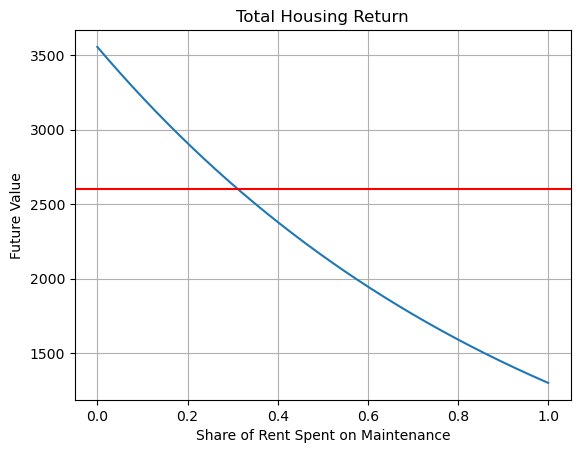

In [14]:
mvec = np.linspace(0,0.9999,1000)
fvvec = [future_value(m) for m in mvec]
plt.plot(mvec, fvvec)
plt.axhline(2600,color="red",label="Stock Return")
plt.xlabel("Share of Rent Spent on Maintenance")
plt.ylabel("Future Value")
plt.grid(True)
plt.title("Total Housing Return")
plt.show()

The graph shows that if more than 30% of rents are spent on taxes, maintenance, etc., stocks were a better investment.